## Using Neural Networks for Convolutional Neural network compression

Our project goal is Compressing deep neural nets, shows how it is possible to reduce the number of parameters in MobileNet-224 from 4 million to 3 million, a 25% saving, while keeping (mostly) the same accuracy.

Short summary: For experimental purposes we remove a few of the filters (output channels) from the convolutional layers. Naturally this makes the accuracy of the neural net worse, so we retrain for a few epochs to compensate. In the interest of saving time, we only train on a small sample (several thousand images) instead of on the entire ImageNet data set (1.28 million images). After pruning the network we plan on writing our own simple neural network to make the pruning process automated for one layer pruning, Our network will predict the optimum threshold value for pruning which indirectly gives maximum accuracy possible and minimum execution/testing time possible.

We start by compressing the layer with maximum number of parameters available for pruning and retrain the network based on the pruning, we pass the training accuracy to the simple MLP and again prune the original network's layer based on a different value given by the MLP. A comparison between the accuracy and testing time of before pruning,after manual pruning and automated pruning is provided in the notebook. You can find the full code and the results in this notebook.

Training was done on a core i7 CPU 4Ghz, using Keras and TensorFlow.

On the original model the validation set accuracy is:

Manual Pruning Statistics:

    Top-5 accuracy over 50000 images = 87.59%
    Before: 4231976 parameters 
    After: 3583656 parameters 
    Saved: 648320 parameters 
    Compressed to 84% of original(considering just one layer)


Accuracy after manual pruning but without Retraining the model:

    Top-5 accuracy over 50000 images = 80.85%

Accuracy after re-training the prunned model on Sample Data:
    
    Top-5 accuracy over 50000 images = 85.93%


Automated Pruning Statistics:

    Before: 4231976 parameters 
    After: 3206820 parameters 
    Saved: 1025156 parameters 
    Compressed to 75.7% of original(considering just one layer)

Accuracy after manual pruning but without Retraining the model:

    Top-5 accuracy over 50000 images = 71%

Accuracy after re-training the prunned model on Sample Data:
    
    Top-5 accuracy over 50000 images = 79.78%

By scaling the input image to 256xN where 256 is the smallest side of the image, and then taking the 224x224 center crop, the original model scores:

The idea forecasted from this project is that we plan on making the pruning process automated and achieving the best possible results without human intervention. There is a definite trade-off between accuracy and execution time as well as a lot of scope for improvement.

### code Reference:- https://gist.github.com/hollance/d15c0cc6004a5479c00ac26bce61ac8d
### To run this notebook you need to download the actual ImageNet dataset (250 GB) or create a sample dataset(25 GB) of validation and test images and their respective labels. 
### ImagNet data: http://image-net.org/challenges/LSVRC/2014/download-images-5jj5.php

## A brief explaination of the topic and the concept

When you compress a neural network, the tradeoff is network size vs. accuracy. In general, the smaller the network, the faster it runs (and the less battery power it uses) but the worse its predictions are. MobileNet scores better than SqueezeNet, for example, but is also 3.4 times larger.

Recall that a convolution layer produces an image with a certain number of output channels. Each of these output channels contains the result of a single convolution filter. Such a filter takes the weighted sum over all the input channels and writes this sum to a single output channel.

After pruning or compressing the convolutional neural networks we retrain the network once again on the sample values and check the accuracy after pruning each layer.

The layers and L1 norm graphs look something like this:

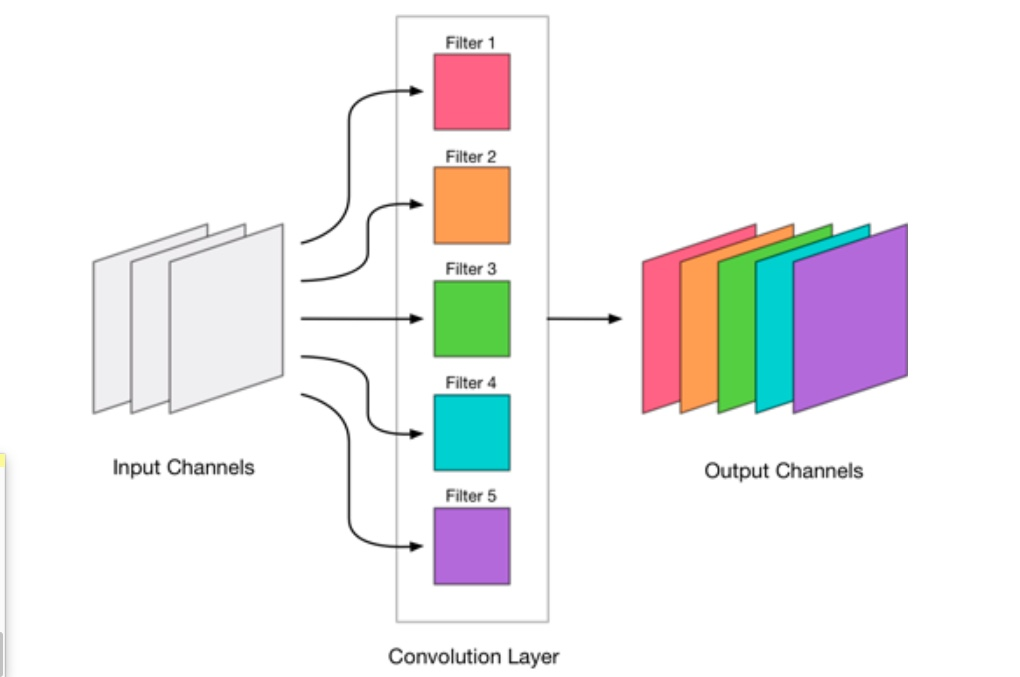

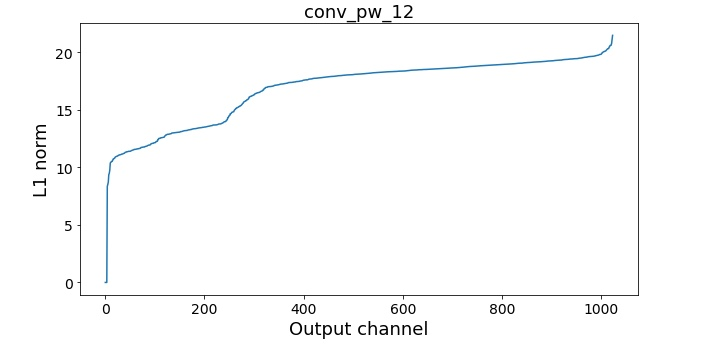

## Steps for sequential execution of the code

    1) import all the necessary libraries and frameworks 
    2) Download the pretrained ImageNet model. 
    3) Download the imageNET dataset required for training and testing the model 
    4) load the training and testing label files 
    5) we will prune a single layer from the model based on the L1 norm values graph and deciding which would be the optimum value of the layers to prune. 
    6) we will train our pruned network again based on random image samples and test it again on a random image sample 
    7) this accuracy will be given as input to our simple MLP(which we trained on sample accuracy and threshold values) written in keras, this MLP will give the optimum value of the number of filters to prune in the layer. 
    8) based on the output of the MLP we will again prune the original CNN based on that value and calculate the accuracy 
    9) The final comparison will be analyzing the accuracy of the network before pruning,after manual pruning and automated pruning


In [1]:
import os
import sys
import time
import random
import numpy as np

from collections import defaultdict
from tqdm import tqdm

import keras
from keras.applications import mobilenet
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Model, load_model
from keras import applications
from keras import optimizers
from keras import backend as K

import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

/Users/kale.pr/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
keras.__version__, tf.__version__

('2.0.7', '1.3.0')

Paths for the labels and images of the dataset

In [15]:
# The directories with the ImageNet data and labels. We're using the
# labels that come with Caffe.
ilsvrc_path = "/Users/kale.pr/Desktop/ADS Data/ILSVRC/Data/"
caffe_path = "/Users/kale.pr/Desktop/ADS Data/ILSVRC2012/caffe_ilsvrc12/"

image_height = 224
image_width = 224
batch_size = 64
num_classes = 1000

## Supporting code

In [4]:
from keras.preprocessing.image import Iterator

class ImageListIterator(Iterator):
    """Iterator yielding data from a list of image names.
    
    This is based on Keras's DirectoryIterator but instead of reading image
    filenames from a directory, it reads them from an array.

    # Arguments
        directory: Path to the directory to read images from.
        image_list: List of image filenames in `directory`.
        labels: Dictionary mapping the image filenames to class indices.
        num_class: Total number of classes.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        target_size: tuple of integers, dimensions to resize input images to.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        image_data_generator
    """

    def __init__(self, directory, image_list, labels, num_class, image_data_generator,
                 target_size=(256, 256), 
                 batch_size=32, shuffle=False, seed=None):

        self.directory = directory
        self.image_list = image_list
        self.samples = len(image_list)
        self.labels = labels
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = target_size
        self.image_shape = self.target_size + (3,)

        print('Found %d images belonging to %d classes.' % (self.samples, self.num_class))

        super(ImageListIterator, self).__init__(self.samples, batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)

        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros((current_batch_size,) + self.image_shape, dtype=K.floatx())
        batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            fname = self.image_list[j].replace("\\","/")
            #print(self.image_list[j].)
            img = image.load_img(os.path.join(self.directory, fname),
                                 target_size=self.target_size)
            #print(self.directory, fname)
            x = image.img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_y[i, self.labels[fname]] = 1  # one-hot encoded            

        return batch_x, batch_y

In [5]:
def divup(a, b):
    """Divides a by b and rounds up to the nearest integer."""
    print((a + b - 1) // b)
    return (a + b - 1) // b


def load_original():
    model = MobileNet(weights="imagenet")
    model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy", "top_k_categorical_accuracy"])
    return model


def load_and_compile(model_path):
    model = load_model(model_path, custom_objects={
                      'relu6': mobilenet.relu6,
                      'DepthwiseConv2D': mobilenet.DepthwiseConv2D})
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["categorical_accuracy", "top_k_categorical_accuracy"])
    return model


def count_weights(model):
    return int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))


def get_l1_norms(model, layer_ix):
    # Get the weights for the layer.
    #print(layer_ix)
    layer = model.layers[layer_ix]
    #print(layer.get_weights())
    W = layer.get_weights()[0]

    # Sum up all the weights for each filter.
    l1 = np.sum(np.abs(W), axis=(0,1,2))

    # Make list of (filter_ix, l1_norm), sorted by l1_norm (low to high).
    l1_norms = sorted(list(zip(range(len(l1)), l1)), key=lambda x: x[1])
    return l1_norms


def plot_l1_norms(model, layer_ix):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(list(map(lambda x: x[1], get_l1_norms(model, layer_ix))))
    plt.xlabel("Output channel", fontsize=18)
    plt.ylabel("L1 norm", fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.title(model.layers[layer_ix].name, fontsize=18)
    

def print_savings(new_model):
    """How much have we compressed the model by pruning?"""
    total_params_after = count_weights(new_model)
    print("Before: %d parameters" % total_params_before)
    print("After: %d parameters" % total_params_after)
    print("Saved: %d parameters" % (total_params_before - total_params_after))
    print("Compressed to %.2f%% of original" % (100*total_params_after / total_params_before))

In [6]:
def create_new_val_sample(size=1000):
    steps = divup(size, batch_size)
    image_list = []
    for img_idx in random.sample(range(1, 50001), steps*batch_size):
        image_list.append("ILSVRC2012_val_000%05d.JPEG" % img_idx)
        #print(image_list)
    return image_list


def eval_on_sample(model, val_sample):
    print(val_data_dir)
    #val_datagen
    gen = ImageListIterator(val_data_dir, val_sample, val_labels, num_classes, val_datagen, 
                            target_size=(image_height, image_width), 
                            batch_size=batch_size)

    steps = len(val_sample) // batch_size
    return model.evaluate_generator(gen, steps=steps)

def eval_full(model):
    """Evaluate the model on the full validation set."""
    gen = ImageListIterator(val_data_dir, val_image_list, val_labels, num_classes, 
                            val_datagen, target_size=(image_height, image_width), 
                            batch_size=batch_size)

    return model.evaluate_generator(gen, steps=divup(50000, batch_size))

In [7]:
def delete_conv_filters(model, layer_ix, channel_indices):
    """Remove output channels from a (pointwise) convolution layer that is 
    followed by a depthwise convolution and a pointwise convolution.
    
    Also removes the corresponding channels from:
    - the BatchNorm layer that follows the conv layer
    - the depthwise conv layer
    - its BatchNorm layer
    - the pointwise conv layer after that
    
    This is necessary because a DepthwiseConv2D layer does not have a filters
    property; it outputs the same number of filters that are passed in.
    """
    
    # Remove the output channels
    layer = model.layers[layer_ix]
    channel_count = layer.get_config()["filters"] - len(channel_indices)
    weights = [np.delete(w, channel_indices, axis=-1) for w in layer.get_weights()]

    # Remove the output channels from the BatchNorm layer as well
    BN_layer = model.layers[layer_ix + 1]
    BN_weights = [np.delete(w, channel_indices, axis=-1) for w in BN_layer.get_weights()]

    # Remove the input channels from the following depthwise conv layer
    dw_layer = model.layers[layer_ix + 3]
    dw_weights = [np.delete(dw_layer.get_weights()[0], channel_indices, axis=2)]
    
    # And from the next layer's BatchNorm layer as well
    dw_BN_layer = model.layers[layer_ix + 4]
    dw_BN_weights = [np.delete(w, channel_indices, axis=-1) for w in dw_BN_layer.get_weights()]
    
    # Remove the input channels from the next conv layer (no bias).
    pw_layer = model.layers[layer_ix + 6]
    pw_weights = [np.delete(pw_layer.get_weights()[0], channel_indices, axis=2)]

    # Dirty trick: this changes the config for the current model, but that
    # does not seem to matter. This is what allows us to make a new model.
    layer.filters = channel_count
    
    return (weights, BN_weights, dw_weights, dw_BN_weights, pw_weights)


def load_new_conv_weights(model, new_model, layer_ix, w1, w2, w3, w4, w5):
    """Load the new weights into the changed layers (this is kinda slow)."""
    for ix in tqdm(range(len(model.layers))):
        layer = model.layers[ix]
        W = layer.get_weights()
        if ix == layer_ix:
            new_model.layers[ix].set_weights(w1)
        elif ix == layer_ix + 1:
            new_model.layers[ix].set_weights(w2)
        elif ix == layer_ix + 3:
            new_model.layers[ix].set_weights(w3)
        elif ix == layer_ix + 4:
            new_model.layers[ix].set_weights(w4)
        elif ix == layer_ix + 6:
            new_model.layers[ix].set_weights(w5)
        elif len(W) > 0:
            new_model.layers[ix].set_weights(W)


def prune_conv_layer(model, layer_ix, num_remove):
    l1_norms = get_l1_norms(model, layer_ix)
    num_original = len(l1_norms)
    print("Pruning %d of %d filters from layer %s" % (num_remove, num_original, model.layers[layer_ix].name))
    
    # Get a sorted list of the filter indices to remove.
    l1_norms_pruned = l1_norms[:num_remove]
    channels_to_prune = sorted(list(map(lambda x: x[0], l1_norms_pruned)))
    
    w1, w2, w3, w4, w5 = delete_conv_filters(model, layer_ix, channels_to_prune)
    
    new_model = model.__class__.from_config(model.get_config(), custom_objects={
                          'relu6': mobilenet.relu6,
                          'DepthwiseConv2D': mobilenet.DepthwiseConv2D})

    # This is just so we can repeat the experiment more than once
    model.layers[layer_ix].filters = num_original
    
    load_new_conv_weights(model, new_model, layer_ix, w1, w2, w3, w4, w5)
    
    new_model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["categorical_accuracy", "top_k_categorical_accuracy"])
    
    return new_model


def prune_last_layer(model, num_remove):
    layer_ix = 79
    l1_norms = get_l1_norms(model, layer_ix)
    num_original = len(l1_norms)
    print("Pruning %d of %d filters from layer %s" % (num_remove, num_original, model.layers[layer_ix].name))

    l1_norms_pruned = l1_norms[:num_remove]
    channel_indices = sorted(list(map(lambda x: x[0], l1_norms_pruned)))

    # Remove the output channels
    layer = model.layers[layer_ix]
    channel_count = layer.get_config()["filters"] - len(channel_indices)
    weights = [np.delete(w, channel_indices, axis=-1) for w in layer.get_weights()]

    # Remove the output channels from the BatchNorm layer as well
    BN_layer = model.layers[layer_ix + 1]
    BN_weights = [np.delete(w, channel_indices, axis=-1) for w in BN_layer.get_weights()]

    # Change the output shape of the reshape layer
    reshape_layer = model.layers[layer_ix + 4]
    reshape_layer.target_shape = (1, 1, channel_count)

    # Remove the input channels from the next conv layer (this layer also has 
    # bias, but we don't need to change those as bias is for output, not input).
    next_layer = model.layers[layer_ix + 6]
    next_weights = [np.delete(next_layer.get_weights()[0], channel_indices, axis=2),
                    next_layer.get_weights()[1]]

    # Dirty trick: this changes the config for the current model, but that
    # does not seem to matter. This is what allows us to make a new model.
    layer.filters = channel_count

    # Create a new model with the changed number of filters
    new_model = model.__class__.from_config(model.get_config(), custom_objects={
                          'relu6': mobilenet.relu6,
                          'DepthwiseConv2D': mobilenet.DepthwiseConv2D})

    # This is just so we can repeat the experiment more than once.
    model.layers[layer_ix].filters = 1024

    for ix in tqdm(range(len(model.layers))):
        layer = model.layers[ix]
        W = layer.get_weights()
        if ix == layer_ix:
            new_model.layers[ix].set_weights(weights)
        elif ix == layer_ix + 1:
            new_model.layers[ix].set_weights(BN_weights)
        elif ix == layer_ix + 6:
            new_model.layers[ix].set_weights(next_weights)
        elif len(W) > 0:
            new_model.layers[ix].set_weights(W)

    new_model.compile(loss="categorical_crossentropy",
                      optimizer="adam",
                      metrics=["categorical_accuracy", "top_k_categorical_accuracy"])
    return new_model

In [8]:
def create_train_sample(train_samples_per_folder):
    """Grabs train_samples_per_folder random image files from each class."""
    train_image_list = []
    for key in list(train_files.keys()):
        for i in range(train_samples_per_folder):
            img_idx = np.random.randint(0, len(train_files[key]))
            img_name = train_files[key][img_idx]
            full_name = os.path.join(key, img_name)
            train_image_list.append(full_name)

    random.shuffle(train_image_list)
    return train_image_list

def train_on_new_sample(model, val_sample, epochs, lr, train_samples_per_folder=5):
    """Train on a random sample of training images. This sample does not change 
    between epochs (but will be shuffled).
    
    self, directory, image_list, labels, num_class, 
                 target_size=(256, 256), 
                 batch_size=32, shuffle=False, seed=None
    """
    
    train_sample = create_train_sample(train_samples_per_folder)
    
    num_train_samples = train_samples_per_folder*num_classes
    num_val_samples = len(val_sample)

    train_gen = ImageListIterator(train_data_dir, train_sample, train_labels, num_classes, 
                                val_datagen, target_size=(image_height, image_width), 
                                  batch_size=batch_size, shuffle=True)

    val_gen = ImageListIterator(val_data_dir, val_sample, val_labels, num_classes, 
                                val_datagen, target_size=(image_height, image_width), 
                                batch_size=batch_size)

    model.optimizer.lr = lr
    #divup(num_train_samples, batch_size)
    #divup(num_val_samples, batch_size)
    model.fit_generator(
        train_gen,
        steps_per_epoch=(num_val_samples//batch_size),
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=1)
    
def train_full(model, epochs, lr):
    """Retrains on the entire ImageNet training set and validates on the
    complete validation set."""
    train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
    
    train_gen = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode="categorical")
    
    val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

    val_gen = ImageListIterator(val_data_dir, val_image_list, val_labels, num_classes, 
                                val_datagen, target_size=(image_height, image_width), 
                                batch_size=batch_size)
    model.optimizer.lr = lr

    num_train_samples = 1281167
    num_val_samples = 50000

    model.fit_generator(
        train_gen,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=divup(num_val_samples, batch_size))    

## Load the model

In [94]:
model = load_original()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [10]:
#
l = model.layers
print(l[79].name)

conv_pw_13


In [11]:

# This is used to compute by how much we've compressed the model.
total_params_before = count_weights(model)
total_params_before

4231976

### Load the names for the classes this model was trained on.

In [16]:
label_names_file = caffe_path + "synset_words.txt"
label_names = np.loadtxt(label_names_file, str, delimiter="\t")

### Load the validation labels into a dictionary.

In [17]:
val_data_dir = ilsvrc_path + "CLS-LOC/val"
val_labels_file = caffe_path + "/val.txt"
val_labels = {}
with open(val_labels_file, "r") as f:
    for line in f.readlines():
        items = line.split(" ")
        val_labels[items[0]] = int(items[1])
#print(val_labels.keys())

### The list of images making up the complete validation set:

In [18]:
val_image_list = []
for img_idx in range(1, 50001):
    val_image_list.append("ILSVRC2012_val_000%05d.JPEG" % img_idx)
print(val_image_list[-1])

ILSVRC2012_val_00050000.JPEG


### Load the training labels and filenames into dictionaries.

In [19]:
train_data_dir = ilsvrc_path + "CLS-LOC/train"
train_labels_file = caffe_path + "train.txt"

train_files = defaultdict(list)
train_labels = {}
with open(train_labels_file, "r") as f:
    for line in f.readlines():
        (path, class_idx) = line.split(" ")
        (class_name, filename) = path.split("/")
        train_labels[path] = int(class_idx)
        train_files[class_name].append(filename)

### Create other objects we need:

In [20]:
val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
#print(train_labels)

## Making predictions

Just to make sure the neural net works OK, predict the outcome for an image from the validation set.

In [21]:
img_name = "ILSVRC2012_val_00000001.JPEG"
img_path = os.path.join(val_data_dir, img_name)
img = image.load_img(img_path, target_size=(image_height, image_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
probabilities = model.predict(x)[0]

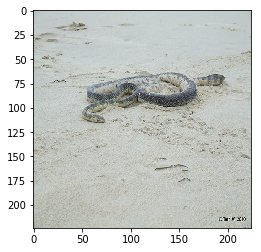

In [22]:
plt.imshow(img)

### Look at the predicted probability distribution over the classes.

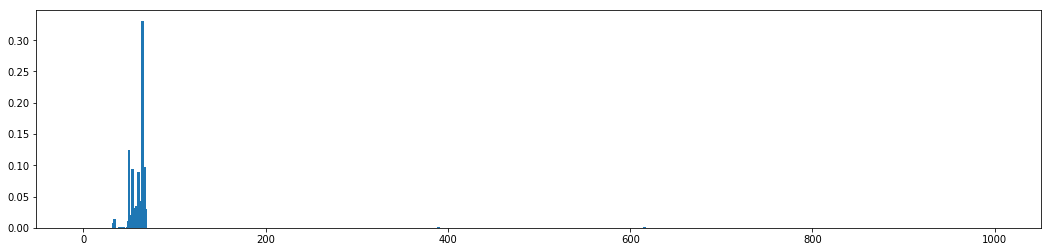

In [23]:
fig = plt.figure(figsize=(18,4))
plt.bar(range(0, 1000), probabilities, width=3)
plt.show()

### Top 5 predictions:

In [24]:
top_ixs = probabilities.argsort()[::-1][:5]
top_ixs
for i in top_ixs:
    print("%.5f %s" % (probabilities[i], label_names[i]))

0.33122 n01751748 sea snake
0.12476 n01698640 American alligator, Alligator mississipiensis
0.09798 n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus
0.09459 n01729322 hognose snake, puff adder, sand viper
0.08988 n01740131 night snake, Hypsiglena torquata


### Ground truth:

In [25]:
print(val_labels[img_name], label_names[val_labels[img_name]])

65 n01751748 sea snake


## What is the accuracy?

Check the model against a (random) sample from the ImageNet validation set.

In [26]:
val_sample = create_new_val_sample()
#print(val_sample[0:5])

16


In [27]:
%time eval_on_sample(model, val_sample)

/Users/kale.pr/Desktop/ADS Data/ILSVRC/Data/CLS-LOC/val
Found 1024 images belonging to 1000 classes.
CPU times: user 7min 56s, sys: 29.3 s, total: 8min 25s
Wall time: 1min 12s


[1.3398114442825317, 0.6875, 0.8759765625]

In [28]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_k_categorical_accuracy']

## L1-norms

To determine which filters to remove, we sort them by L1-norm and remove the filters with the smallest L1-norms. You can read more about this approach in the paper [Pruning Filters For Efficient Convnets](https://arxiv.org/abs/1608.08710) by Li et al.

Plot the L1-norms for all layers. This should give some idea of how many filters we can remove per layer.

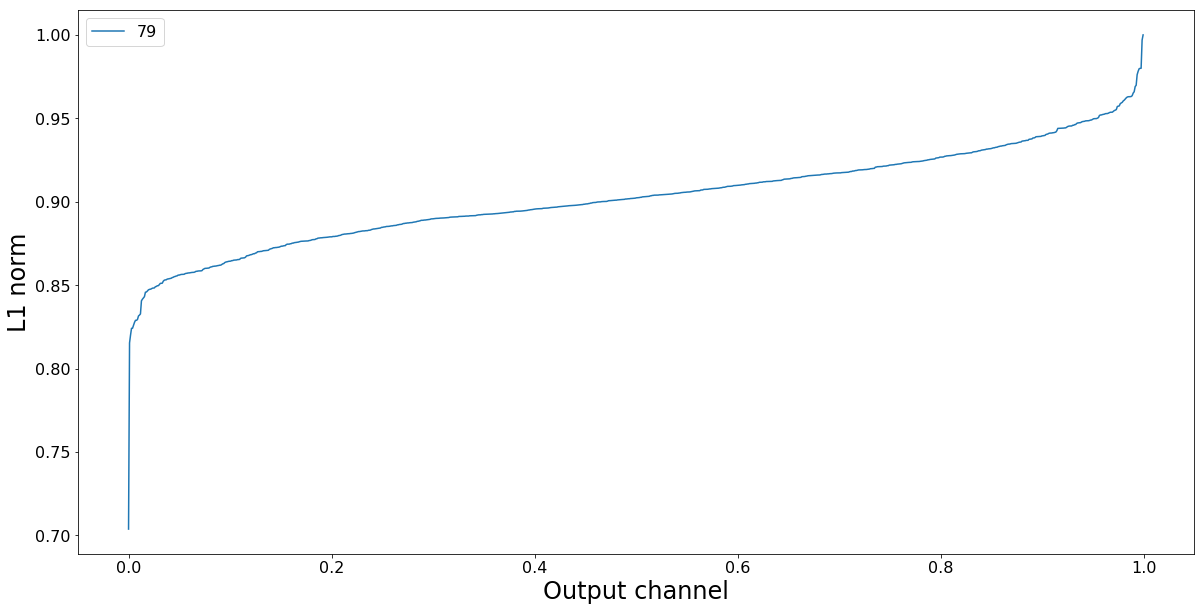

In [29]:
# Indices of the layers with convolutions (excluding depthwise)
layer_ixs = [79]
    #1,7, 13, 19, 25, 31, 37, 43, 49, 55, 61, 67, 73, 79]

fig = plt.figure(figsize=(20, 10))

for layer_ix in layer_ixs:
    l1_norms = get_l1_norms(model, layer_ix)
    max_value = l1_norms[-1][1]
    xs = np.arange(0, 1, 1. / len(l1_norms))
    ys = list(map(lambda x: x[1] / max_value, l1_norms))
    plt.plot(xs, ys)
    
plt.legend(layer_ixs, fontsize=16)
plt.xlabel("Output channel", fontsize=24)
plt.ylabel("L1 norm", fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)

Vertical axis is L1-norm divided by maximum L1-norm for that layer. Horizontal axis is (sorted) filter index divided by total number of filters for that layer. (This is like Fig 2(a) in the Li paper, but sorted from low to high.)

## Compression by removing filters

We can only remove filters (output channels) from the first convolution layer and the pointwise convolution layers.

Depthwise convolution layers cannot be compressed by removing output channels, since they need to have as many output channels as input channels. Besides, depthwise convolution layers don't really have that many parameters and are quite fast. And when we prune the other layers, we also prune the corresponding channels from the depthwise layers that follow.

It also makes no sense to remove output channels from the classification layer (`conv_preds`), since we need it to output predictions for all 1000 categories.

We start with the last layer in the network, since that is the biggest layer and we can make most gains here. (Because I want to be able to use this neural net with Metal, we must always remove filters in multiples of 4.)

### conv_pw_13

This is the last convolution layer before the classification layer (which also happens to be convolutional in Keras's implementation of MobileNet).

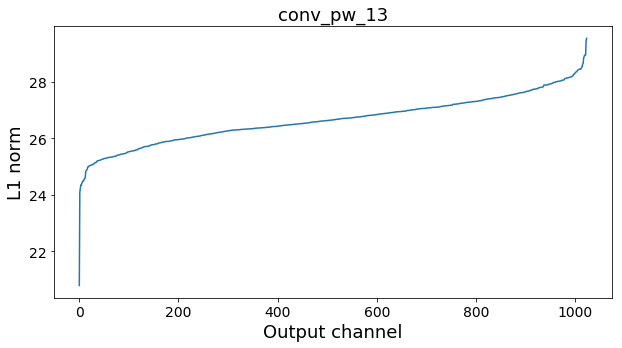

In [30]:
plot_l1_norms(model, 79)

In [31]:

new_model = prune_last_layer(model, num_remove=320)

Pruning 320 of 1024 filters from layer conv_pw_13


100%|██████████| 88/88 [00:04<00:00, 21.76it/s]


In [100]:
print_savings(new_model)

Before: 4231976 parameters
After: 3583656 parameters
Saved: 648320 parameters
Compressed to 84.68% of original


In [32]:
%time eval_on_sample(new_model, val_sample)

/Users/kale.pr/Desktop/ADS Data/ILSVRC/Data/CLS-LOC/val
Found 1024 images belonging to 1000 classes.
CPU times: user 7min 53s, sys: 28.7 s, total: 8min 21s
Wall time: 1min 12s


[1.8525399193167686, 0.5927734375, 0.80859375]

We've removed 25% of this layer's filters and the accuracy dropped by 10 points. We'll now retrain to try and recover from this.

In [33]:
train_on_new_sample(new_model, val_sample, epochs=10, lr=0.00003, train_samples_per_folder=10)

Found 10000 images belonging to 1000 classes.
Found 1024 images belonging to 1000 classes.
Epoch 1/10
16/16 [==============================] - 213s - loss: 1.9614 - categorical_accuracy: 0.5576 - top_k_categorical_accuracy: 0.8076 - val_loss: 1.8105 - val_categorical_accuracy: 0.5781 - val_top_k_categorical_accuracy: 0.8438
Epoch 2/10
16/16 [==============================] - 211s - loss: 1.8550 - categorical_accuracy: 0.5723 - top_k_categorical_accuracy: 0.8076 - val_loss: 1.6919 - val_categorical_accuracy: 0.5156 - val_top_k_categorical_accuracy: 0.8750
Epoch 3/10
16/16 [==============================] - 211s - loss: 1.8167 - categorical_accuracy: 0.5850 - top_k_categorical_accuracy: 0.8047 - val_loss: 1.4452 - val_categorical_accuracy: 0.6406 - val_top_k_categorical_accuracy: 0.8906
Epoch 4/10
16/16 [==============================] - 220s - loss: 1.7922 - categorical_accuracy: 0.5908 - top_k_categorical_accuracy: 0.8203 - val_loss: 1.3982 - val_categorical_accuracy: 0.7031 - val_top_

Note how we're overfitting on the training sample: the training loss keeps going down, and the training accuracy gets to 1.0, but the validation loss mostly stays the same after the first 5 epochs.

In [36]:
#%time eval_full(new_model)
%time eval_on_sample(new_model, val_sample)

/Users/kale.pr/Desktop/ADS Data/ILSVRC/Data/CLS-LOC/val
Found 1024 images belonging to 1000 classes.
CPU times: user 7min 46s, sys: 30.7 s, total: 8min 17s
Wall time: 1min 23s


[1.5404912829399109, 0.64453125, 0.859375]

In [37]:
img_name = "ILSVRC2012_val_00000001.JPEG"
img_path = os.path.join(val_data_dir, img_name)
img = image.load_img(img_path, target_size=(image_height, image_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
probabilities = new_model.predict(x)[0]

0.29904 n01740131 night snake, Hypsiglena torquata
0.17212 n01737021 water snake
0.10421 n01744401 rock python, rock snake, Python sebae
0.07383 n01753488 horned viper, cerastes, sand viper, horned asp, Cerastes cornutus
0.06461 n01751748 sea snake


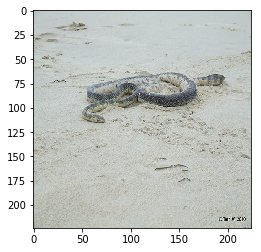

In [38]:
plt.imshow(img)

top_ixs = probabilities.argsort()[::-1][:5]
top_ixs
for i in top_ixs:
    print("%.5f %s" % (probabilities[i], label_names[i]))

In [39]:
new_model.save("mobilenet_compressed_conv_pw_13.h5", include_optimizer=False)

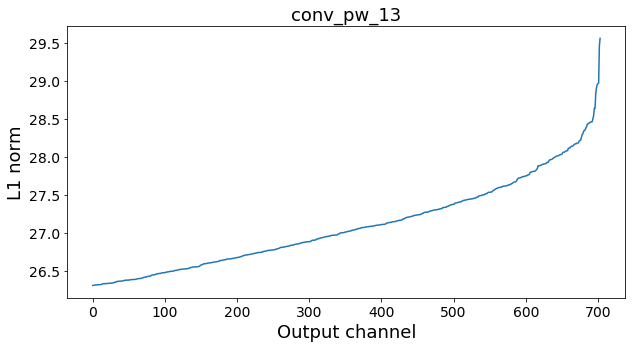

In [40]:
plot_l1_norms(new_model, 79)

# Chceking Accuracy after Pruning the model by the Ratio given by our NN

In [93]:
import sklearn.model_selection
from keras.layers import Dense, Dropout, Flatten, Reshape
import numpy as np
import pandas as pd


# Load Datasets
df_train  = pd.read_csv('/Users/kale.pr/Desktop/training_data_MLP.csv')

# To numpy array - dataset of train
x_train = df_train.drop(['Threshold'], axis=1).values
y_train = keras.utils.np_utils.to_categorical(df_train['Threshold'].values)


# Define model

mymodel = keras.models.Sequential()
mymodel.add(keras.layers.normalization.BatchNormalization(input_shape=tuple([x_train.shape[1]])))
mymodel.add(keras.layers.core.Dense(32, activation='relu'))
mymodel.add(keras.layers.core.Dropout(rate=0.5))
mymodel.add(keras.layers.normalization.BatchNormalization())
mymodel.add(keras.layers.core.Dense(32, activation='relu'))
mymodel.add(keras.layers.core.Dropout(rate=0.5))
mymodel.add(keras.layers.normalization.BatchNormalization())
mymodel.add(keras.layers.core.Dense(32, activation='relu'))
mymodel.add(keras.layers.core.Dropout(rate=0.))
mymodel.add(keras.layers.core.Dense(24,activation='sigmoid'))

mymodel.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
print(mymodel.summary())

# Train model
#, verbose=1, callbacks=[callback_early_stopping
mymodel.fit(x_train, y_train, batch_size=1024, epochs=10, validation_data=(x_train, y_train))

# Predict test dataset
df_test = pd.DataFrame(columns=['Accuracy', 'PrunRatio'])
df_test['Accuracy'] = [57]
df_test['PrunRatio'] = [15]
x_test = df_test.values
y_test = mymodel.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_44 (Batc (None, 2)                 8         
_________________________________________________________________
dense_88 (Dense)             (None, 32)                96        
_________________________________________________________________
dropout_43 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 32)                128       
_________________________________________________________________
dense_89 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 32)                128       
__________

In [92]:
np.average(y_test)*1024

553.2454223632812

In [96]:
new_model2 = prune_last_layer(model, num_remove=506)
#model.summary()

Pruning 506 of 1024 filters from layer conv_pw_13


100%|██████████| 88/88 [00:41<00:00,  2.14it/s]


In [97]:
%time eval_on_sample(new_model2, val_sample)

/Users/kale.pr/Desktop/ADS Data/ILSVRC/Data/CLS-LOC/val
Found 1024 images belonging to 1000 classes.
CPU times: user 7min 52s, sys: 30.7 s, total: 8min 23s
Wall time: 1min 12s


[2.5138330459594727, 0.4609375, 0.716796875]

In [98]:
train_on_new_sample(new_model2, val_sample, epochs=10, lr=0.00003, train_samples_per_folder=10)

Found 10000 images belonging to 1000 classes.
Found 1024 images belonging to 1000 classes.
Epoch 1/10
16/16 [==============================] - 221s - loss: 2.5193 - categorical_accuracy: 0.4619 - top_k_categorical_accuracy: 0.7129 - val_loss: 2.3760 - val_categorical_accuracy: 0.4688 - val_top_k_categorical_accuracy: 0.7344
Epoch 2/10
16/16 [==============================] - 215s - loss: 2.4165 - categorical_accuracy: 0.4619 - top_k_categorical_accuracy: 0.7227 - val_loss: 2.2128 - val_categorical_accuracy: 0.4844 - val_top_k_categorical_accuracy: 0.7188
Epoch 3/10
16/16 [==============================] - 216s - loss: 2.3945 - categorical_accuracy: 0.4736 - top_k_categorical_accuracy: 0.7412 - val_loss: 2.0487 - val_categorical_accuracy: 0.5625 - val_top_k_categorical_accuracy: 0.8281
Epoch 4/10
16/16 [==============================] - 224s - loss: 2.3821 - categorical_accuracy: 0.4658 - top_k_categorical_accuracy: 0.7363 - val_loss: 2.0690 - val_categorical_accuracy: 0.5312 - val_top_

In [99]:
%time eval_on_sample(new_model2, val_sample)

/Users/kale.pr/Desktop/ADS Data/ILSVRC/Data/CLS-LOC/val
Found 1024 images belonging to 1000 classes.
CPU times: user 7min 54s, sys: 31.5 s, total: 8min 25s
Wall time: 1min 12s


[1.98494803160429, 0.5595703125, 0.7978515625]

In [101]:
print_savings(new_model2)

Before: 4231976 parameters
After: 3206820 parameters
Saved: 1025156 parameters
Compressed to 75.78% of original


## Our Conclusions:

We have successfully put forth the idea of automated pruning of Convolutional Neural networks. 
###### Pros: 
1. We have achieved the same execution time of automated pruning and manual pruning which means there is no significant overhead of the network which was expected. 
2. The saved model is less in size as compared to the previous model

###### cons: 
1. We faced a accuracy drop of 5% for one layer automated pruning and after retrining on complete dataset and trainning images we predict this accuracy loss to be somewhere between 1-3% 
2. We didn't consider a few of important factors such as batch_size, pruning ratio, number of filters which would save the model's accuracy to a much better extent if considered in the MLP.
